##6주차 강화학습 과제

과제는 총 2개의 환경인 CartPole과 MountainCar로 이루어져 있습니다.

CartPole의 경우 강화학습의 실행 환경 이해를 위해 학습 전,후 결과 영상을 비교해보시고

MountainCar의 경우 할인율(Gamma)에 따른 학습 결과 비교를 해주세요.

In [1]:
!pip uninstall gym -y
!pip install gymnasium[classic-control]
!pip install numpy==1.23.5

In [2]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display

env = gym.make("CartPole-v1", render_mode='rgb_array')

bins = [
    np.linspace(-4.8, 4.8, 16),
    np.linspace(-5.0, 5.0, 16),
    np.linspace(-0.418, 0.418, 16),
    np.linspace(-5.0, 5.0, 16)
]

def discretize_state(obs):
    return tuple(int(np.digitize(obs[i], bins[i])) for i in range(len(obs)))

def collect_fixed_frames(env, policy, fixed_steps=500):
    frames = []
    obs, _ = env.reset()
    for _ in range(fixed_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        if done:
            obs, _ = env.reset()
    return frames

def display_animation(frames, interval=20):
    fig = plt.figure(figsize=(6,4))
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=interval)
    plt.close()
    return HTML(anim.to_jshtml())


In [3]:
print("학습 전 랜덤 정책(실패하면 환경 초기화)")
random_policy = lambda obs: env.action_space.sample()
frames_random = collect_fixed_frames(env, random_policy, fixed_steps=500)
display(display_animation(frames_random, interval=20))

Output hidden; open in https://colab.research.google.com to view.

Episode: 0, Total reward: 27.0, Epsilon: 0.9995
Episode: 500, Total reward: 29.0, Epsilon: 0.7784
Episode: 1000, Total reward: 59.0, Epsilon: 0.6062
Episode: 1500, Total reward: 56.0, Epsilon: 0.4720
Episode: 2000, Total reward: 37.0, Epsilon: 0.3676
Episode: 2500, Total reward: 102.0, Epsilon: 0.2863
학습 종료 at episode 2873, total_reward: 500.0


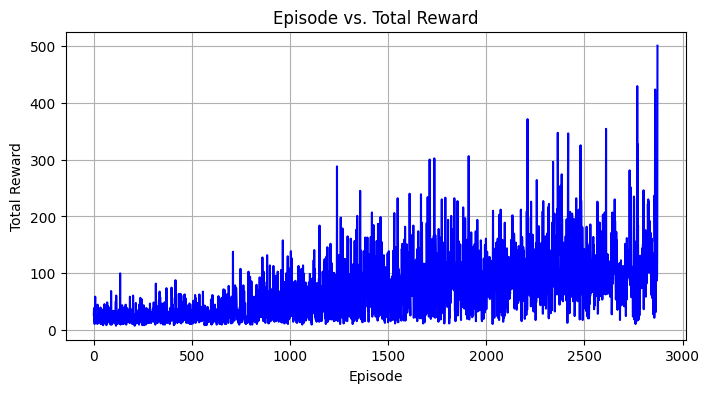

In [4]:
q_table = np.zeros([17, 17, 17, 17, env.action_space.n])

alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.9995

max_episodes = 20000
episode_rewards = []  # 그래프 출력을 위한 보상 기록
episode = 0

while True:
    obs, _ = env.reset()
    state = discretize_state(obs)
    done = False
    total_reward = 0

    while not done:
        # epsilon-greedy 정책
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])

        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = discretize_state(next_obs)

        q_table[state + (action,)] += alpha * (
            reward + gamma * np.max(q_table[next_state]) - q_table[state + (action,)]
        )

        state = next_state
        total_reward += reward

    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    episode_rewards.append(total_reward)

    # 진행 상황 출력
    if episode % 500 == 0:
        print(f"Episode: {episode}, Total reward: {total_reward}, Epsilon: {epsilon:.4f}")

    episode += 1

    if total_reward == 500 or episode >= max_episodes:
        print(f"학습 종료 at episode {episode}, total_reward: {total_reward}")
        break

# 에피소드별 total reward 변화 그래프 출력
plt.figure(figsize=(8, 4))
plt.plot(episode_rewards, color='blue')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Episode vs. Total Reward')
plt.grid(True)
plt.show()

In [5]:
print("학습 후 정책 시각화 (500점 도달 시점)")
def learned_policy(obs):
    return np.argmax(q_table[discretize_state(obs)])

frames_learned = collect_fixed_frames(env, learned_policy, fixed_steps=500)
display(display_animation(frames_learned, interval=20))

Output hidden; open in https://colab.research.google.com to view.

## MountainCar

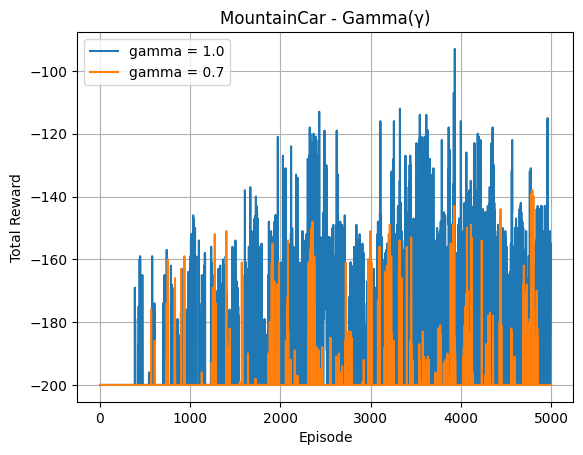

In [6]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import imageio
from IPython.display import HTML, display
import base64
import os

# 환경 생성
env = gym.make("MountainCar-v0", render_mode="rgb_array")

# 상태 이산화
def discretize_state(state, bins=(18, 14)):
    pos, vel = state
    pos_bin = np.digitize(pos, np.linspace(-1.2, 0.6, bins[0]))
    vel_bin = np.digitize(vel, np.linspace(-0.07, 0.07, bins[1]))
    return (pos_bin, vel_bin)

# Q-learning
def q_learning(gamma=1.0, episodes=5000, alpha=0.1, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards = []
    best_Q = None
    best_reward = -float("inf")

    for ep in range(episodes):
        obs, _ = env.reset()
        state = discretize_state(obs)
        done = False
        total_reward = 0

        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = discretize_state(next_obs)

            best_next = np.max(Q[next_state])
            Q[state][action] += alpha * (reward + gamma * best_next - Q[state][action])

            state = next_state
            total_reward += reward

        rewards.append(total_reward)

        if total_reward > best_reward:
            best_reward = total_reward
            best_Q = Q.copy()

    return rewards, best_Q

# 학습 실행
rewards_g1, best_q_g1 = q_learning(gamma=1.0)
rewards_g07, best_q_g07 = q_learning(gamma=0.5)

# 보상 그래프
plt.plot(rewards_g1, label="gamma = 1.0")
plt.plot(rewards_g07, label="gamma = 0.7")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("MountainCar - Gamma(γ)")
plt.legend()
plt.grid()
plt.show()

# 영상 저장 함수
def render_policy(Q, filename="output.mp4"):
    frames = []
    obs, _ = env.reset()
    state = discretize_state(obs)
    done = False

    while not done:
        frame = env.render()
        frames.append(frame)
        action = np.argmax(Q[state])
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = discretize_state(obs)

    env.close()
    imageio.mimsave(filename, frames, fps=30)
    return filename

# 영상 재생 함수
def display_video(filename):
    video_file = open(filename, "rb").read()
    encoded = base64.b64encode(video_file).decode()
    html = f"""
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{encoded}" type="video/mp4">
    </video>
    """
    display(HTML(html))

# 영상 생성 및 재생
file_g1 = render_policy(best_q_g1, "gamma1.mp4")
file_g07 = render_policy(best_q_g07, "gamma07.mp4")

In [7]:
# 감마 1.0 영상 보기
display_video("gamma1.mp4")

In [8]:
# 감마 0.7 영상 보기
display_video("gamma07.mp4")

Gamma에 따른 학습 그래프를 해석해보고 왜 이러한 결과가 나왔는지 적어주세요!

정답: gamma=1.0은 미래의 보상까지 충분히 고려하여,더 나은 학습 성능과 전략을 형성한다.
반면, gamma=0.7은 가까운 보상에 집중해서 산을 넘는 데 필요한 행동을 학습하지 못하고, 성능이 낮다.